# Etiquetado de los datos versión 3
---

En este tercer intento, vamos a intentar determinar si un alumno abandonó la asignatura considerando la cantidad de veces que accedió al aula virtual durante el periodo que abarca la ventana de destino, del 17 de noviembre al 25 de diciembre de 2023 . Para ello, será necesario calcular esta métrica sobre los logs del sistema relativos a la asignatura, contenidos en la tabla `alumnos_ip_cmi`.

## Configuración de la sesión

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, lit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import count
from pyspark.sql.functions import from_unixtime, date_format
import os

ruta_origen = "/home/carlos/Documentos/TFG/spark-workspace/data/raw/"
ruta_destino = "/home/carlos/Documentos/TFG/spark-workspace/data/etiquetas"
courseid_ip = 8683
os.makedirs(ruta_destino, exist_ok=True)

# Crear sesión Spark
spark = SparkSession.builder \
    .appName("Creacion de metricas de los cuestionarios") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

## Cálcular accesos por alumno en el periodo indicado

In [13]:
from pyspark.sql.functions import to_date, from_unixtime

# Cargar datos log
df_log_ip = spark.read.parquet(f"{ruta_origen}/log_ip_cmi.parquet")
df_log_ip = df_log_ip.drop("courseid")

#Cargar datos alumnos
df_alumnos_ip = spark.read.parquet(f"{ruta_origen}/alumnos_ip_cmi.parquet")

#Quedarnos solo con las entradas de la ventana de destino
df_log_date = df_log_ip.withColumn("date", to_date(from_unixtime(col("timecreated"))))

df_log_destino = df_log_date.filter(
      (col("date") >= "2023-11-18") & (col("date") <= "2023-12-25")) \
.orderBy("date")

# Nos quedamos solo con los accesos al curso (No hace falta unir con alummnos matriculados ya que los logs estan calculados solo para ellos)
df_accesos_alumnos = df_log_destino.filter(
(col("component") == "core") & # Indicar el módulo de moodle que ha registrado la entrada, en este caso al tratarse de un acceso al aula virtual debe ser core
(col("action") == "viewed") & # Indicar la acción que se ha realizado, en este caso un acceso al aula virtual
(col("contextinstanceid") == courseid_ip) #Pasar el id del curso como contextinstanceid , dado que así indicamos que el acceso ha sido al curso y no a un recurso del mismo
)


df_accesos_alumnos = df_accesos_alumnos.select("userid", "date")
num_accesos = df_accesos_alumnos.count()
print(f"Número de accesos al curso en la ventana de destino hechos por alumnos matriculados: {num_accesos}")

# Agrupar por usuario y obtener número de accesos por alumno matriculado en el periodo considerado
df_accesos_por_usuario = df_accesos.groupBy("userid").agg(count("*").alias("num_accesos"))

df_accesos_por_usuario.show(truncate=False)

Número de accesos al curso en la ventana de destino hechos por alumnos matriculados: 12702
+----------------------------------------------------------------+-----------+
|userid                                                          |num_accesos|
+----------------------------------------------------------------+-----------+
|3b8d431cbee3182d06225f9d5ab51f5806e8042f145e0ad0e37d98f56ae78f3d|30         |
|368093a57fe640879a9fc57ecb7e2c846b7dadf19620bfc9c4c001daeaf9af0f|27         |
|b10bfb431460e96f99322635d8c44d0fb4f74302c61334119ab1c842e049fac1|43         |
|e86f7c2d50f4fa9ee5b3f8bf9a25af4c9ef573fa28a0c8c50df815971efa0529|37         |
|bc941ebd72011adc6a5fbaa15a85c36e9dd20fd0af0156317b764f98a7a099ee|60         |
|3fbb342bde31891ebf3e9cf181af68784afd73186c29470f6ecc1a18c3fc9bdb|1          |
|fecb23a186e5f25b262b2c956854799d90380949847cd1c63c2b67d01855a68c|40         |
|e1d0ac5ca3713be41636fae3ba32c8653800af198126c08205853259bdd6382d|56         |
|88d2b1d26bf274fb33b99ca95cf5cdf6b7bbba7

## Visualizar resultados

📊 Estadísticas y alumnos bajo el umbral:
- Q1 = 37.00 → Alumnos con accesos ≤ Q1: 50
- Mediana = 58.00 → Alumnos con accesos ≤ mediana: 100
- Q3 = 86.00
- Media = 64.48


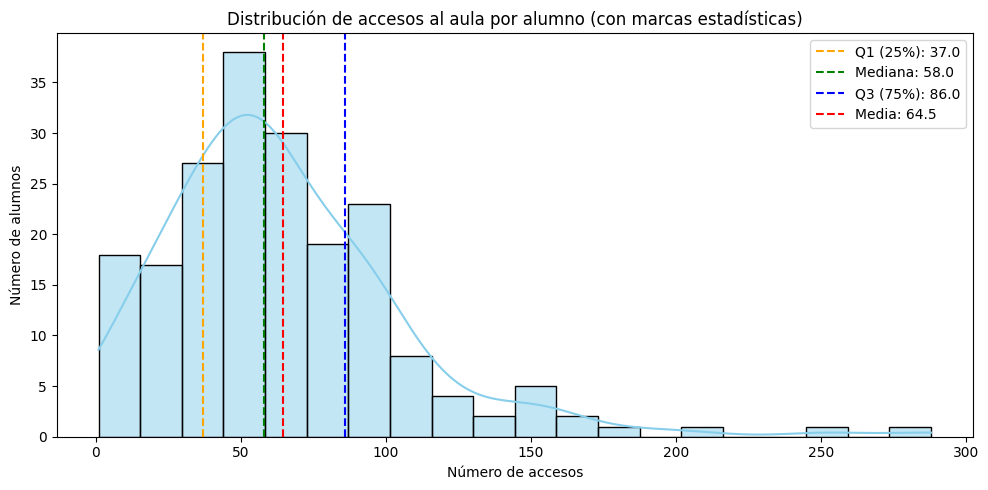

In [16]:

# Convertir a pandas
df_accesos_pd = df_accesos_por_usuario.toPandas()

# Cálculo de estadísticas
media = df_accesos_pd["num_accesos"].mean()
mediana = df_accesos_pd["num_accesos"].median()
cuartiles = df_accesos_pd["num_accesos"].quantile([0.25, 0.5, 0.75])
q1 = cuartiles.loc[0.25]
q2 = cuartiles.loc[0.5]
q3 = cuartiles.loc[0.75]

# Contar alumnos por debajo o igual de cada valor
n_q1 = df_accesos_pd[df_accesos_pd["num_accesos"] <= q1].shape[0]
n_mediana = df_accesos_pd[df_accesos_pd["num_accesos"] <= mediana].shape[0]

# Mostrar conteos
print("📊 Estadísticas y alumnos bajo el umbral:")
print(f"- Q1 = {q1:.2f} → Alumnos con accesos ≤ Q1: {n_q1}")
print(f"- Mediana = {mediana:.2f} → Alumnos con accesos ≤ mediana: {n_mediana}")
print(f"- Q3 = {q3:.2f}")
print(f"- Media = {media:.2f}")

# Gráfico
plt.figure(figsize=(10, 5))
sns.histplot(df_accesos_pd["num_accesos"], bins=20, kde=True, color="skyblue")

# Líneas de referencia
plt.axvline(q1, color='orange', linestyle='--', label=f'Q1 (25%): {q1:.1f}')
plt.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.1f}')
plt.axvline(q3, color='blue', linestyle='--', label=f'Q3 (75%): {q3:.1f}')
plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.1f}')

# Etiquetas y estilo
plt.title("Distribución de accesos al aula por alumno (con marcas estadísticas)")
plt.xlabel("Número de accesos")
plt.ylabel("Número de alumnos")
plt.legend()
plt.tight_layout()
plt.show()


## Análisis de resultados

Tras observar los datos, podríamos ver que la media de accesos está en 58, y que si eligieramos como umbral de abandono el  primer cuartil Q1 = 37.0 , 50 alumnos de la clase están por debajo de este valor. 

Dado que parece razonable por lo calculado según las otras normas de etiquetado que aproximadamente 50 alumnos abandonaran la asignatura, podríamos considerar este valor como umbral de abandono, y por lo tanto considerar que los 50 alumnos por debajo de este abandonaron la asignatura. 



## Etiquetado final y exportar csv



In [ ]:
#Marcamos solo como true en la columna abandona si el número de accesos es menor o igual que el primer cuartil
df_etiquetado_accesos = df_accesos_por_usuario.withColumn("abandona_por_accesos", col("num_accesos") <= q1)
df_etiquetado_accesos.show(truncate=False)
df_etiquetado_accesos = df_etiquetado_accesos.drop("num_accesos")

# Guardar el DataFrame etiquetado
df = df_etiquetado_accesos.toPandas()
df.to_csv(f"{ruta_destino}/etiquetado_abandono_v3.csv", index=False)


+----------------------------------------------------------------+-----------+--------------------+
|userid                                                          |num_accesos|abandona_por_accesos|
+----------------------------------------------------------------+-----------+--------------------+
|3b8d431cbee3182d06225f9d5ab51f5806e8042f145e0ad0e37d98f56ae78f3d|30         |true                |
|368093a57fe640879a9fc57ecb7e2c846b7dadf19620bfc9c4c001daeaf9af0f|27         |true                |
|b10bfb431460e96f99322635d8c44d0fb4f74302c61334119ab1c842e049fac1|43         |false               |
|e86f7c2d50f4fa9ee5b3f8bf9a25af4c9ef573fa28a0c8c50df815971efa0529|37         |true                |
|bc941ebd72011adc6a5fbaa15a85c36e9dd20fd0af0156317b764f98a7a099ee|60         |false               |
|3fbb342bde31891ebf3e9cf181af68784afd73186c29470f6ecc1a18c3fc9bdb|1          |true                |
|fecb23a186e5f25b262b2c956854799d90380949847cd1c63c2b67d01855a68c|40         |false               |
